In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import datetime
import csv
import config
from torch.utils.data import random_split

In [2]:
# --- Dataset ---
class JetbotDataset(Dataset):
    def __init__(self, image_dir, csv_path, image_size, num_prev_frames, transform=None):
        self.image_dir = image_dir
        self.csv_path = csv_path
        self.image_size = image_size
        self.transform = transform
        self.num_prev_frames = num_prev_frames
        self.image_paths, self.actions = self.load_data()
        self.image_paths = self.image_paths[self.num_prev_frames:]
        self.actions = self.actions[self.num_prev_frames:]


    def load_data(self):
        image_paths = []
        actions = []
        with open(self.csv_path, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_paths.append(row['image_path'])
                actions.append(float(row['action']))
        return image_paths, actions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        current_image_path = self.image_paths[idx]
        current_image = Image.open(current_image_path).convert("RGB")
        current_action = self.actions[idx]

        prev_frames = []
        for i in range(self.num_prev_frames):
            prev_image_path = self.image_paths[idx - (self.num_prev_frames - i)]
            prev_image = Image.open(prev_image_path).convert("RGB")
            if self.transform:
                prev_image = self.transform(prev_image)
            prev_frames.append(prev_image)

        if self.transform:
            current_image = self.transform(current_image)

        prev_frames_tensor = torch.cat(prev_frames, dim=0)

        return current_image, torch.tensor([current_action], dtype=torch.float32), prev_frames_tensor

# --- Diffusion Helpers ---
def linear_beta_schedule(timesteps, beta_start, beta_end):
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, betas, alphas_cumprod, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(torch.sqrt(alphas_cumprod), t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        torch.sqrt(1. - alphas_cumprod), t, x_0.shape
    )
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# --- U-Net Model ---
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUNet(nn.Module):
    def __init__(self, image_channels=3, down_channels=(64, 128, 256), up_channels=(256, 128, 64), time_emb_dim=32, num_prev_frames=4):
        super().__init__()
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels * (num_prev_frames + 1), down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim + 1) \
                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim + 1, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)


    def forward(self, x, timestep, action, prev_frames):
        x = torch.cat([x, prev_frames], dim=1)

        t = self.time_mlp(timestep)
        if action is not None:
            action = action.float()
            if len(action.shape) == 1:
                action = action.unsqueeze(1)
            t = torch.cat([t, action], dim=1)

        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

# --- Training Loop ---
def train(model, dataloader, optimizer, betas, start_epoch, num_epochs, device, save_every, sample_every, checkpoint_dir, sample_dir, plot_dir, plot_every, use_fp16, accumulation_steps, num_prev_frames):
    all_losses = []
    start_time = time.time()
    last_plot_epoch = 0

    scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_losses = []
        optimizer.zero_grad()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for step, (images, actions, prev_frames) in enumerate(pbar):
            images = images.to(device)
            actions = actions.to(device)
            prev_frames = prev_frames.to(device)
            t = torch.randint(0, config.NUM_TIMESTEPS, (images.shape[0],), device=device).long()

            with torch.cuda.amp.autocast(enabled=use_fp16):
                x_noisy, noise = forward_diffusion_sample(images, t, betas, alphas_cumprod, device)
                predicted_noise = model(x_noisy, t, actions, prev_frames)
                loss = F.mse_loss(noise, predicted_noise)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_losses.append(loss.item() * accumulation_steps)
            pbar.set_postfix({"Loss": loss.item() * accumulation_steps})
        if optimizer.param_groups[0]['params'][0].grad is not None: #Ensure optimizer had a step
             scaler.step(optimizer)
             scaler.update()
             optimizer.zero_grad()

        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        all_losses.append(avg_epoch_loss)

        if (epoch + 1) % save_every == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }, os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth"))  # Save to checkpoint dir
            print(f"Saved model checkpoint at epoch {epoch+1}")

        if (epoch + 1) % sample_every == 0:
            model.eval()
            with torch.no_grad():
                # 1. Randomly sample a frame and its history from the dataset
                random_idx = torch.randint(0, len(dataset), (1,)).item()
                real_current_frame, action, real_prev_frames = dataset[random_idx]
                real_current_frame = real_current_frame.unsqueeze(0).to(device) # (C, H, W) -> (1, C, H, W)
                real_prev_frames = real_prev_frames.unsqueeze(0).to(device)  # (N*C, H, W) -> (1, N*C, H, W)
                action = action.to(device)

                # 2. Noise the current frame
                t_sample = torch.tensor([config.NUM_TIMESTEPS - 1], device=device, dtype=torch.long)
                x_noisy, _ = forward_diffusion_sample(real_current_frame, t_sample, betas, alphas_cumprod, device)
                x = x_noisy

                # 3. Denoise (sample)
                for i in reversed(range(1, config.NUM_TIMESTEPS)):
                    t = (torch.ones(1) * i).long().to(device)
                    with torch.cuda.amp.autocast(enabled=use_fp16):
                        predicted_noise = model(x, t, action, real_prev_frames)

                    alpha = alphas[t][:, None, None, None]
                    alpha_hat = alphas_cumprod[t][:, None, None, None]
                    beta = betas[t][:, None, None, None]

                    if i > 1:
                        noise = torch.randn_like(x)
                    else:
                        noise = torch.zeros_like(x)
                    x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                predicted_next_frame = (x.clamp(-1, 1) + 1) / 2  # Un-normalize: [-1, 1] -> [0, 1]
                predicted_next_frame = (predicted_next_frame * 255).type(torch.uint8) # [0, 1] -> [0, 255]

                # 4. Prepare for visualization
                #    - Convert prev_frames to a list of PIL Images
                prev_images = []
                for i in range(num_prev_frames):
                    frame = real_prev_frames[0, (i * 3):(i + 1) * 3, :, :]  # Extract each frame (C, H, W)
                    frame = (frame.clamp(-1, 1) + 1) / 2 # Unnormalize
                    frame = (frame * 255).type(torch.uint8) # To uint8
                    prev_images.append(transforms.ToPILImage()(frame))

                #    - Convert current_frame to PIL Image
                current_image = (real_current_frame[0].clamp(-1, 1) + 1) / 2  # Un-normalize: [-1, 1] -> [0, 1]
                current_image = (current_image * 255).type(torch.uint8)       # [0, 1] -> [0, 255]
                current_image = transforms.ToPILImage()(current_image).convert("RGB")
                #    - Convert predicted_next_frame to PIL Images
                predicted_image = transforms.ToPILImage()(predicted_next_frame[0])

                # 5. Create visualization (side-by-side)
                total_width = (num_prev_frames + 2) * config.IMAGE_SIZE
                max_height = config.IMAGE_SIZE
                new_im = Image.new('RGB', (total_width, max_height))

                x_offset = 0
                for image in prev_images:
                    new_im.paste(image, (x_offset,0))
                    x_offset += config.IMAGE_SIZE
                new_im.paste(current_image, (x_offset, 0))
                x_offset += config.IMAGE_SIZE
                new_im.paste(predicted_image, (x_offset, 0))


                # 6. Save the combined image
                new_im.save(os.path.join(sample_dir, f"sample_epoch_{epoch+1}.png"))
                print(f"Saved sample image at epoch {epoch+1}")
            model.train()

        if (epoch + 1) % plot_every == 0:
            elapsed_time = time.time() - start_time
            formatted_time = str(datetime.timedelta(seconds=elapsed_time))

            fig, axes = plt.subplots(1, 2, figsize=(16, 5))

            axes[0].plot(all_losses)
            axes[0].set_xlabel("Epoch")
            axes[0].set_ylabel("Loss")
            axes[0].set_title(f"Training Loss from Start (Time: {formatted_time})")
            axes[0].grid(True)

            axes[1].plot(range(last_plot_epoch + 1, epoch + 2), all_losses[last_plot_epoch:])
            axes[1].set_xlabel("Epoch")
            axes[1].set_ylabel("Loss")
            axes[1].set_title(f"Loss Since Last Plot (Epoch {last_plot_epoch + 1})")
            axes[1].grid(True)

            plt.tight_layout()
            plt.savefig(os.path.join(plot_dir, f"loss_plot_epoch_{epoch+1}.png"))  # Save to plot dir
            plt.close()
            print(f"Epoch {epoch+1}: Loss = {avg_epoch_loss:.4f}, Time = {formatted_time}")

            last_plot_epoch = epoch


    end_time = time.time()
    total_time = end_time - start_time
    formatted_time = str(datetime.timedelta(seconds=total_time))
    print(f"Total training time: {formatted_time}")

    return all_losses

In [5]:
# --- Data Transforms ---
transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Create Dataset and DataLoader ---
dataset = JetbotDataset(config.IMAGE_DIR, config.CSV_PATH, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=transform)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch size 1 for easier evaluation

# --- Calculate Betas and Alphas ---
betas = linear_beta_schedule(config.NUM_TIMESTEPS, config.BETA_START, config.BETA_END).to(config.DEVICE)
#betas = cosine_beta_schedule(NUM_TIMESTEPS).to(DEVICE) # Alternative

alphas = (1. - betas).to(config.DEVICE)
alphas_cumprod = torch.cumprod(alphas, axis=0).to(config.DEVICE)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0).to(config.DEVICE)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(config.DEVICE)

# --- Create Model and Optimizer ---
model = SimpleUNet(image_channels=3, down_channels=(64, 128, 256), up_channels=(256, 128, 64), time_emb_dim=32, num_prev_frames=config.NUM_PREV_FRAMES).to(config.DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

# --- Load Checkpoint (if available) ---
if config.LOAD_CHECKPOINT:
    checkpoint = torch.load(config.LOAD_CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    START_EPOCH = checkpoint['epoch']
    print(f"Loaded checkpoint from epoch {START_EPOCH}")
else:
    START_EPOCH = 0

# --- Train the Model ---
losses = train(model, train_dataloader, optimizer, betas, START_EPOCH, config.NUM_EPOCHS, config.DEVICE,
               config.SAVE_MODEL_EVERY, config.SAMPLE_EVERY, config.CHECKPOINT_DIR, config.SAMPLE_DIR, config.PLOT_DIR, config.PLOT_EVERY, config.USE_FP16,
               config.ACCUMULATION_STEPS, config.NUM_PREV_FRAMES)
print("Training complete!")

# --- Final Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.savefig(os.path.join(config.PLOT_DIR, "loss_plot_final.png"))  # Save to plot dir
plt.close()

Epoch 1/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/32 [00:00<?, ?it/s]

Saved sample image at epoch 20
Epoch 20: Loss = 0.1252, Time = 0:00:28.039582


Epoch 21/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/32 [00:00<?, ?it/s]

Saved sample image at epoch 40
Epoch 40: Loss = 0.0857, Time = 0:00:56.500792


Epoch 41/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/32 [00:00<?, ?it/s]

Saved sample image at epoch 60
Epoch 60: Loss = 0.0505, Time = 0:01:24.794345


Epoch 61/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/32 [00:00<?, ?it/s]

Saved sample image at epoch 80
Epoch 80: Loss = 0.0360, Time = 0:01:53.495966


Epoch 81/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/32 [00:00<?, ?it/s]

Saved sample image at epoch 100
Epoch 100: Loss = 0.0288, Time = 0:02:22.748237
Total training time: 0:02:23.026237
Training complete!


In [7]:
config.SAMPLE_EVERY

20

In [44]:
transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = JetbotDataset(config.IMAGE_DIR, config.CSV_PATH, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=transform)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [45]:
def display_dataset_entry(dataset_entry):
    frame,action,previous_frames = dataset_entry
    print(f'Action: {action}')
    display_frame(frame)
    for i in range(config.NUM_PREV_FRAMES):
        frame = previous_frames[(i * 3):(i + 1) * 3, :, :]  # Extract each frame (C, H, W)
        display_frame(frame)


def display_frame(frame):
    frame = (frame.clamp(-1, 1) + 1) / 2 # Unnormalize
    frame = (frame * 255).type(torch.uint8) # To uint8
    display(transforms.ToPILImage()(frame))


In [50]:
len(test_dataset)

416

Action: tensor([0.])


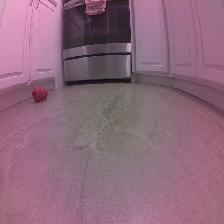

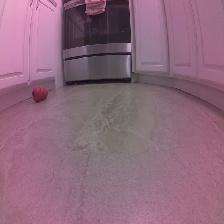

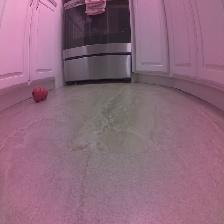

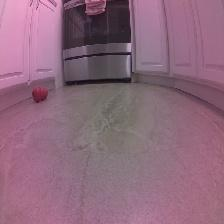

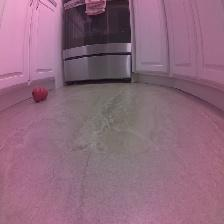

In [52]:
#display_dataset_entry(train_dataset[1201])
display_dataset_entry(test_dataset[401])

In [25]:
dataset[25][2].shape

torch.Size([12, 224, 224])